In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [3]:
TICKER = 'AAPL'
TRAINING_DAYS = 3 * 365
FEATURE_WINDOW = 30
TARGET_WINDOW = 5
TEST_SPLIT_RATIO = 0.2
RANDOM_STATE = 42
ANNUAL_FACTOR = 252


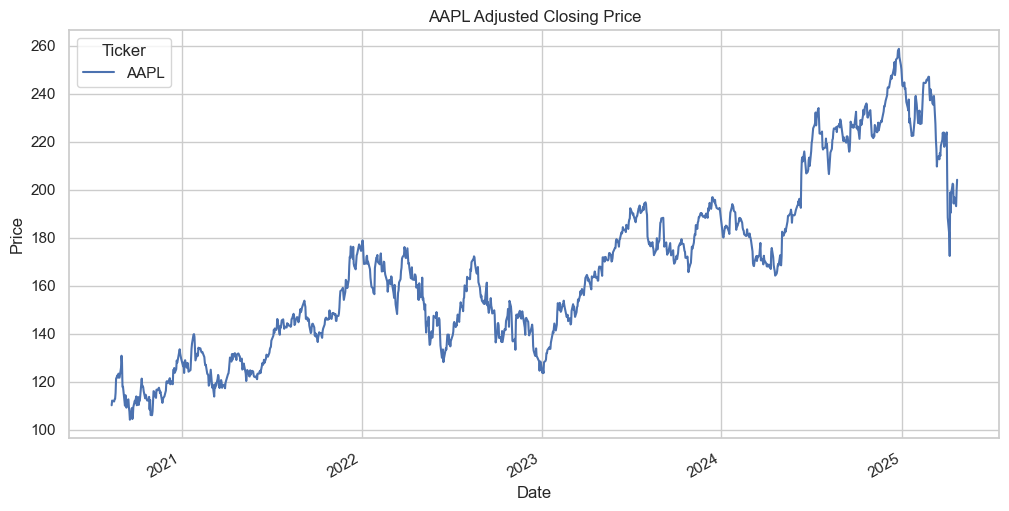

In [4]:
def fetch_data(ticker, period_days):
    df = yf.download(ticker, period=f"{period_days}d", auto_adjust=True, progress=False)
    if df.empty: raise ValueError(f"No data for {ticker}.")
    
    if "Adj Close" in df.columns:
        price_df = df[["Adj Close"]].copy()
    elif "Close" in df.columns:
        price_df = df[["Close"]].rename(columns={"Close": "Adj Close"})
    else:
        raise ValueError("No Close/Adj Close column found.")
        
    price_df.dropna(inplace=True)
    return price_df.tail(period_days)

raw_data = fetch_data(TICKER, TRAINING_DAYS + FEATURE_WINDOW + TARGET_WINDOW + 50)
raw_data['Adj Close'].plot(title=f'{TICKER} Adjusted Closing Price')
plt.ylabel('Price')
plt.show()


In [5]:
def prepare_features_and_target(data, feature_window, target_window, annual_factor):
    df = data.copy()
    df['log_return'] = np.log(df['Adj Close'].div(df['Adj Close'].shift(1)))
    
    min_periods_feature = int(feature_window * 0.8)
    min_periods_target = int(target_window * 0.8)
    
    df['rolling_volatility'] = (
        df['log_return']
        .rolling(window=feature_window, min_periods=min_periods_feature)
        .std(ddof=0)
        * np.sqrt(annual_factor)
    )
    
    df['rolling_mean_return'] = (
        df['log_return']
        .rolling(window=feature_window, min_periods=min_periods_feature)
        .mean()
        * annual_factor
    )
    
    df['future_realised_volatility'] = (
        df['log_return']
        .rolling(window=target_window, min_periods=min_periods_target)
        .std(ddof=0)
        .shift(-target_window)
        * np.sqrt(annual_factor)
    )
    
    df.dropna(inplace=True)
    if df.empty: raise ValueError("No data left after feature engineering.")
    return df

feature_data = prepare_features_and_target(raw_data, FEATURE_WINDOW, TARGET_WINDOW, ANNUAL_FACTOR)
print(feature_data.head())


Price        Adj Close log_return rolling_volatility rolling_mean_return  \
Ticker            AAPL                                                     
Date                                                                       
2020-09-16  109.337807  -0.029958           0.495702           -0.082085   
2020-09-17  107.592392  -0.016092           0.488157           -0.241012   
2020-09-18  104.179550  -0.032234           0.488107           -0.544165   
2020-09-21  107.338882   0.029875           0.488516           -0.245176   
2020-09-22  109.025795   0.015594           0.482189           -0.096078   

Price      future_realised_volatility  
Ticker                                 
Date                                   
2020-09-16                   0.440617  
2020-09-17                   0.451241  
2020-09-18                   0.445586  
2020-09-21                   0.433016  
2020-09-22                   0.439334  


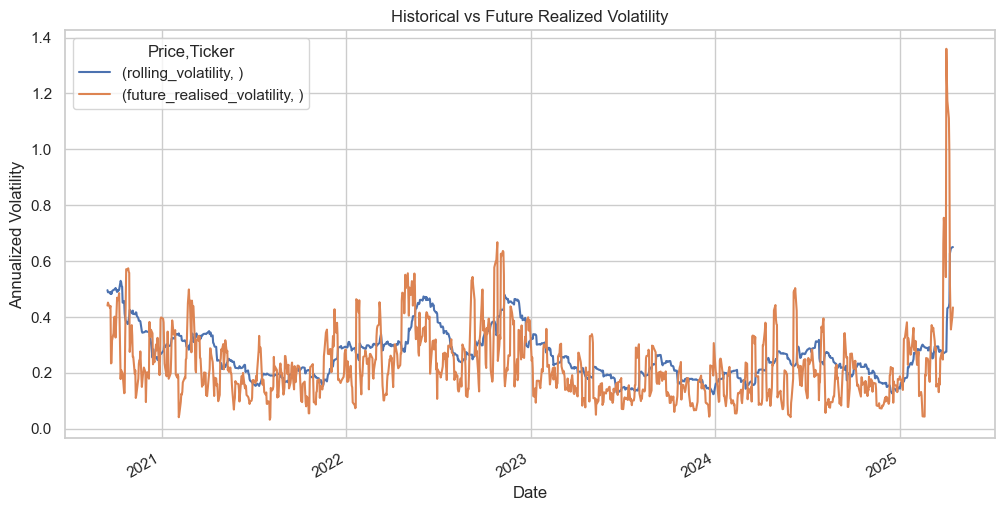

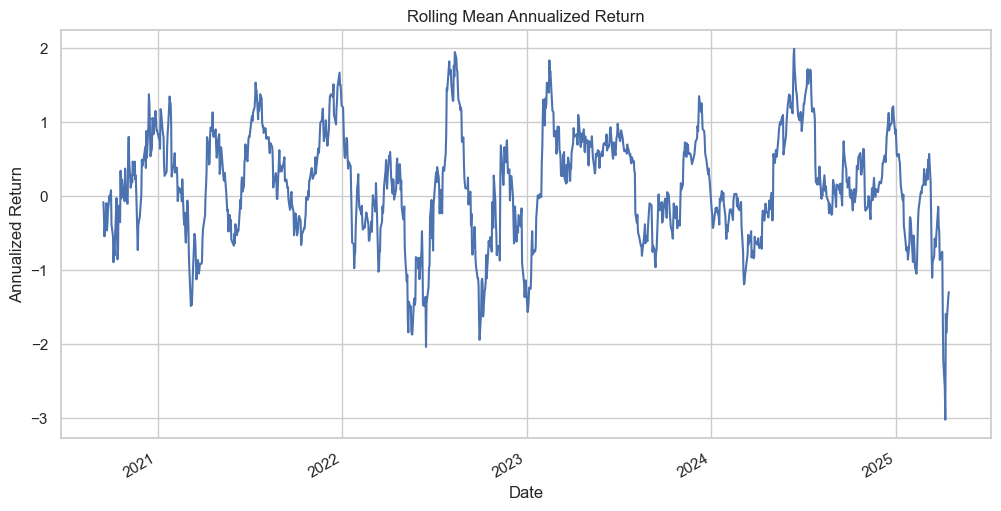

In [6]:
feature_data[['rolling_volatility', 'future_realised_volatility']].plot(title='Historical vs Future Realized Volatility')
plt.ylabel('Annualized Volatility')
plt.show()

feature_data['rolling_mean_return'].plot(title='Rolling Mean Annualized Return')
plt.ylabel('Annualized Return')
plt.show()


In [7]:
FEATURES = ['rolling_volatility', 'rolling_mean_return']
TARGET = 'future_realised_volatility'

X = feature_data[FEATURES]
y = feature_data[TARGET]

split_index = int(len(X) * (1 - TEST_SPLIT_RATIO))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 920, Test size: 231


In [8]:
gbr_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    loss='squared_error',
    random_state=RANDOM_STATE
)

gbr_model.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

Test Set RMSE: 0.1769


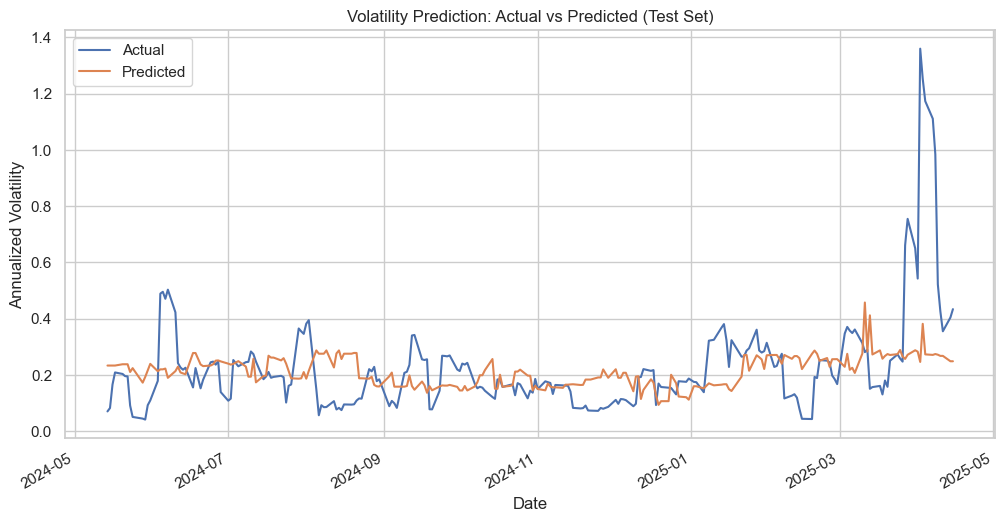

In [9]:
y_pred = gbr_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test Set RMSE: {rmse:.4f}")

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

results.plot(title='Volatility Prediction: Actual vs Predicted (Test Set)')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.legend()
plt.show()


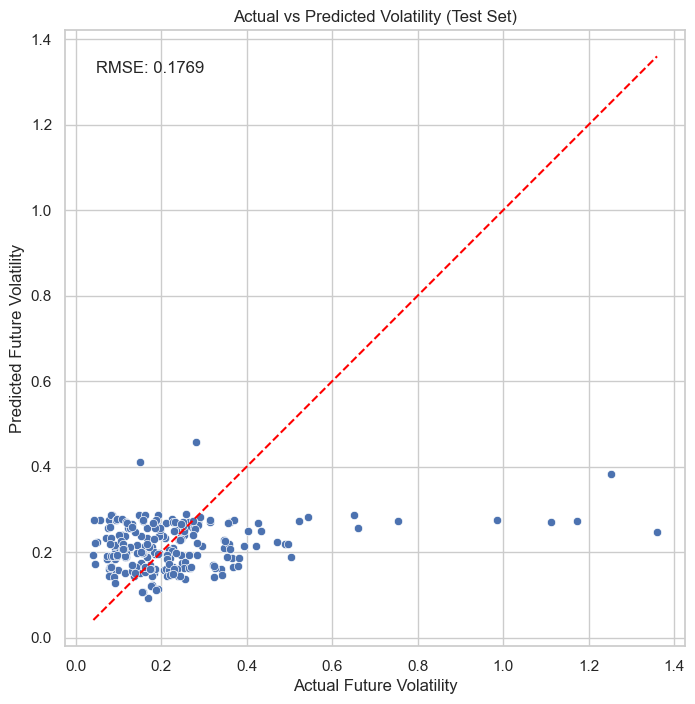

In [10]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=results)
plt.plot([results.min().min(), results.max().max()], [results.min().min(), results.max().max()], color='red', linestyle='--')
plt.title('Actual vs Predicted Volatility (Test Set)')
plt.xlabel('Actual Future Volatility')
plt.ylabel('Predicted Future Volatility')
plt.text(0.05, 0.95, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.axis('equal')
plt.show()


In [11]:
latest_features = X.iloc[[-1]]
print("\nLatest features used for prediction:")
print(latest_features)

predicted_sigma = gbr_model.predict(latest_features)[0]

if predicted_sigma <= 0:
    last_known_rolling_vol = latest_features['rolling_volatility'].iloc[0]
    predicted_sigma = last_known_rolling_vol if last_known_rolling_vol > 0 else 0.01

print(f"\nPredicted Annualized Volatility for the next {TARGET_WINDOW} days: {predicted_sigma:.4f} ({predicted_sigma*100:.2f}%)")



Latest features used for prediction:
Price      rolling_volatility rolling_mean_return
Ticker                                           
Date                                             
2025-04-15           0.649831           -1.298427

Predicted Annualized Volatility for the next 5 days: 0.2486 (24.86%)
